In [287]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
import pylab
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
# from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [288]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)

2) Convert `default` and `student` to categorical variables.

In [289]:
df_default=pd.get_dummies(df['default'])
df_default=df_default.drop(['No'],1)
df_default.rename(columns={'Yes':'default'}, inplace=True)

df_student=pd.get_dummies(df['student'])
df_student=df_student.drop(['No'],1)
df_student.rename(columns={'Yes':'student'}, inplace=True)
df_final = pd.concat([df_default, df_student, df[['balance', 'income']]],axis=1 )
df_final.head(5)

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

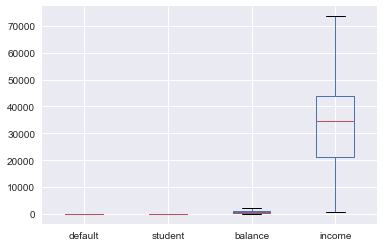

In [290]:
df_final.boxplot()
plt.show()

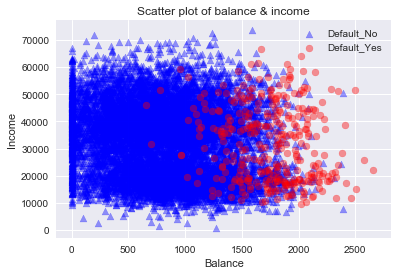

In [291]:
Red = df_final[df_final['default'] > 0]
Blue = df_final[df_final['default'] < 1]
fig, ax = plt.subplots()
ax.set_xlabel('Balance')
ax.set_ylabel('Income')
ax.set_title('Scatter plot of balance & income')
ax.scatter(Blue['balance'], Blue['income'],  color='b', marker='^', alpha=.4, label='Default_No')
ax.scatter(Red['balance'], Red['income'], color='r', alpha=.4, label='Default_Yes')
ax.legend(loc='upper right')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

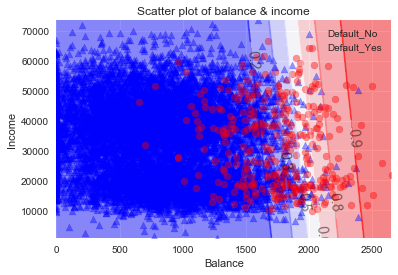

In [292]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

X = df_final[['balance', 'income']]
y = df_final[['default']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

logistic = LogisticRegression(penalty='l1')
logistic.fit(X_train, y_train)
predict = logistic.predict(X_test)

# Decison boundary
h = 50
x_min, x_max = df_final[['balance']].min() - 0.5, df_final[['balance']].max() + 0.5
y_min, y_max = df_final[['income']].min() - 0.5, df_final[['income']].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

ax = plt.gca()
Z = logistic.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
cs = ax.contourf(xx, yy, Z, cmap='bwr', alpha=.5)
cs2 = ax.contour(xx, yy, Z, cmap='bwr', alpha=.5)
plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)

# Plot the scatter plot in (3)
plt.scatter(Blue['balance'], Blue['income'],  color='b', marker='^', alpha=.4, label='Default_No')
plt.scatter(Red['balance'], Red['income'], color='r', alpha=.4, label='Default_Yes')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.title('Scatter plot of balance & income')
plt.legend(loc='upper right')
plt.show()


Area under the ROC curve : 0.960663


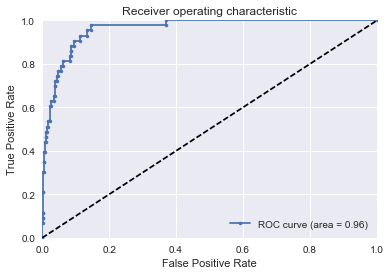

In [293]:
# AUC ROC
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    fig = plt.figure()
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

The optimal alpha is : 3.51119173422
Area under the ROC curve : 0.962252


/Users/hanbing/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


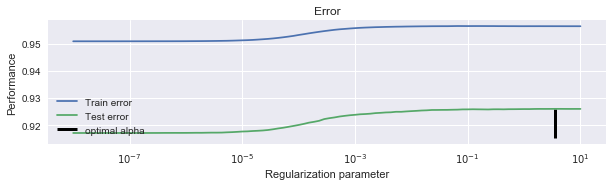

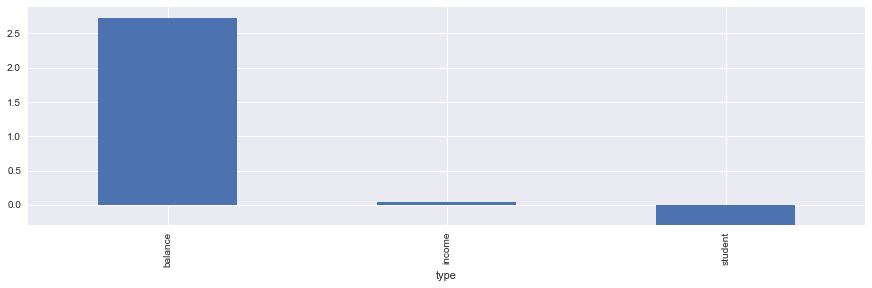

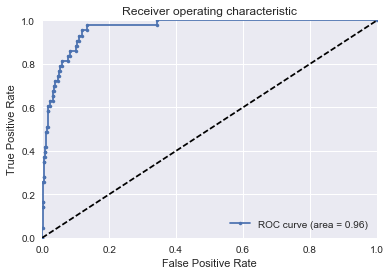

In [281]:
from sklearn.linear_model import Ridge
X = df_final[['student','balance','income']]
y = df_final['default']

scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
                                                  
# Ridge regression
alphas = np.logspace(-8,1,100)
train_errors = list()
test_errors = list()
for alpha in alphas:
    logreg = LogisticRegression(C=alpha,penalty='l2') 
    logreg.fit(X_train, y_train)
   
    probas_ = logreg.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    train_errors.append(roc_auc)
    
    probas_ = logreg.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    test_errors.append(roc_auc)

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]

print("The optimal alpha is : %s" % alpha_optim)

plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train error')
plt.semilogx(alphas, test_errors, label='Test error')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='optimal alpha')

#plt.ylim(0.915, 0.955)
plt.legend(loc='lower left')
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')
plt.title('Error')

#plot ranking of coefficients
coef =  LogisticRegression(C=alpha_optim,penalty='l2').fit(X,y).coef_
dfCoeffs = pd.DataFrame({'type':df_final.columns.values[1:], 'coef':coef[0]})
plt.figure(figsize=(15,4))
dfCoeff = dfCoeffs.groupby('type')['coef'].mean()
dfCoeff.sort()
dfCoeff[::-1].plot(kind='bar')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=alpha_optim,penalty='l2')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

plt.show()

$Answer:$

From the plots above, we can infer that the optimal alpha is 3.51119173422; As for the 3 coefficients, we can see the coefficient of balance is much larger than the other two; Referring to the AUC ROC, we can see that after using Rodge regression, the value change from 0.960663 to 0.962252, which increases a little bit.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [347]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, y, cv=5)
scores   

array([ 0.96651674,  0.96651674,  0.9665    ,  0.96598299,  0.96648324])

$Answer:$

From the result above, we can see the scores are all close to 1.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

Automatically created module for IPython interactive environment


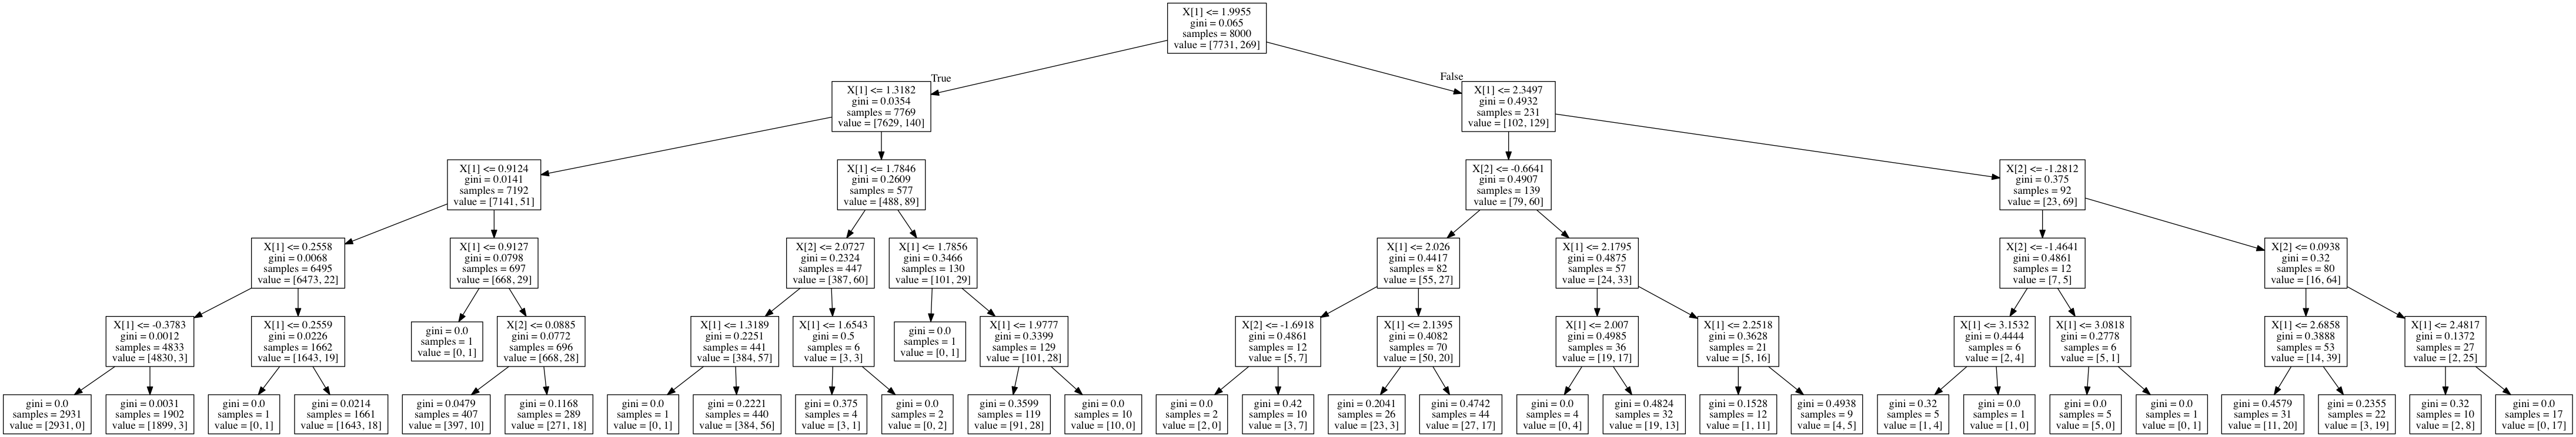

In [331]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy.random as nprnd
from PIL import Image, ImageFilter
import graphviz
import pydotplus
from __future__ import print_function
import os
import subprocess
from PIL import Image, ImageFilter
from IPython.display import Image

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        

X = df_final[['student','balance','income']]
y = df_final['default']
scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)

print(__doc__)
%matplotlib inline

regr = DecisionTreeClassifier(max_depth=5)
regr.fit(X_train, y_train)
y = regr.predict(X_test)


dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr, feature_names=['x'])


dot_data=export_graphviz(regr, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Area under the ROC curve : 0.932280


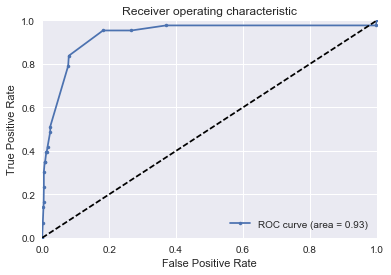

In [332]:
plt.figure(figsize=(10,10))
y = df_final['default']
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth=5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

$Solution:$

From the plot above, we can see that when the depth is 5, the AUC ROC is 0.954498, so we can draw a conclusion that a decision tree classifier of depth 5 works worse than ridge regression.

8) Find the optimal decision tree depth and compute the AUC ROC. 

optimal depth is 3


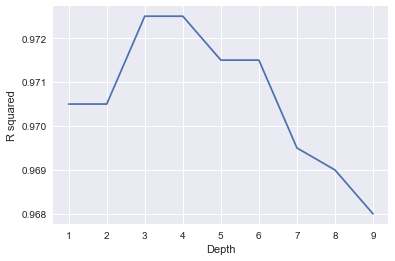

In [343]:
test_errors = []
scores = []
depths = range(1,10)
for n in depths:
    clf = DecisionTreeClassifier(max_depth=n)
    clf.fit(X_train, y_train)
    train_errors.append(clf.score(X_train,y_train))
    scores.append(clf.score(X_test,y_test))
    
plt.ylabel('R squared')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
print ("optimal depth is" , n_opt)

Area under the ROC curve : 0.951562


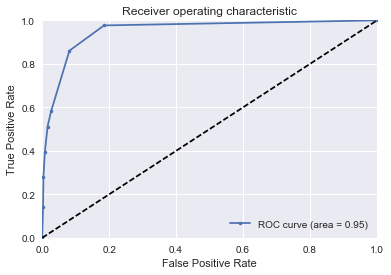

In [344]:
X = df_final[['student','balance','income']]
y = df_final['default']
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth=3)
generate_ROCplot(fpr,tpr,'LR',roc_auc)